In [ ]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math

%matplotlib inline

In [ ]:
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) / resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    max_window = int(max_window) #ADDED LINE
    for w in range(2, int(len(data) / max_window + 1)): #ADDED INT CASTING
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size

In [ ]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        max_lag = int(max_lag) #ADDED LINE
        self.correlations = R_t[:max_lag].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range) #ADDED LINE
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    _range = int(_range) #ADDED LINE
    slide = int(slide) #ADDED LINE
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

In [ ]:
# Read data from CSV
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data

In [ ]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()

In [ ]:
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html

# Plot time series of two different sets of data
def plot_multiple(dataToSmooth, dataToCompare, window_size, slide_size):
    temp = SMA(dataToSmooth, slide_size, slide_size)
    smoothed = SMA(temp, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    
    print(smoothed_range)

    fig, ax1 = plt.subplots()

    color1 = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sentiment', color=color1)
    ax1.plot(smoothed_range, smoothed, color=color1, linestyle='-', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color2 = 'tab:blue'
    ax2.set_ylabel('Stock Price', color=color2)  # we already handled the x-label with ax1
    ax2.plot(dataToCompare, color=color2, linestyle='-', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout(w_pad=1)  # otherwise the right y-label is slightly clipped
    fig.set_size_inches(16, 6)
    plt.show()

Window Size:  302
range(151, 1507)


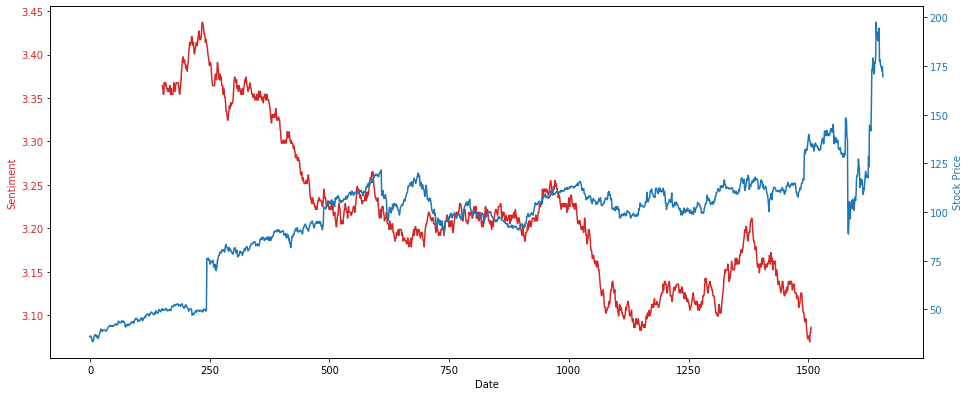

In [ ]:
# Sentiment
sentiment_data = load_csv('usable_sentiment.csv')
sentiment_data_int = [int(a) for a in sentiment_data]
window_size, slide_size = smooth_ASAP(sentiment_data_int, resolution=1920)
# Finance
finance_data = load_csv('usable_finance.csv')

print("Window Size: ", window_size)
plot_multiple(raw_data, finance_data, window_size, slide_size)

Window Size:  302
range(151, 1507)


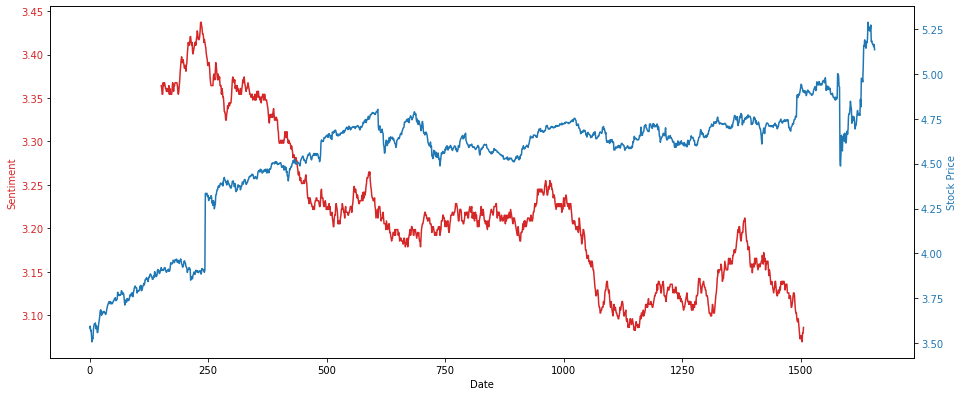

In [ ]:
## NATURAL LOG OF STOCK PRICE

# Sentiment
sentiment_data = load_csv('usable_sentiment.csv')
sentiment_data_int = [int(a) for a in sentiment_data]
window_size, slide_size = smooth_ASAP(sentiment_data_int, resolution=1920)
# Finance
finance_data = load_csv('usable_finance.csv')
finance_data = [np.log(x) for x in finance_data]

print("Window Size: ", window_size)
plot_multiple(raw_data, finance_data, window_size, slide_size)

Window Size:  302


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

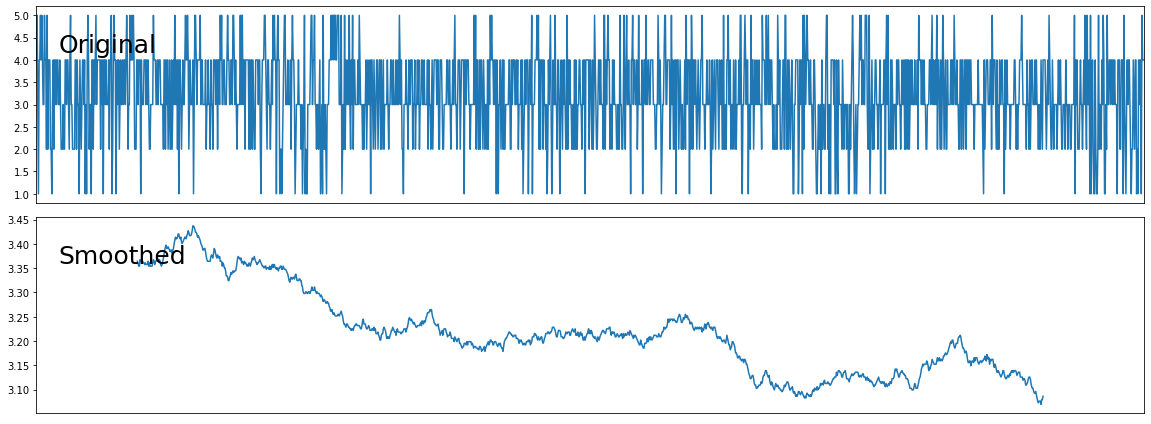

In [ ]:
# Sentiment
raw_data = load_csv('usable_sentiment.csv')
raw_data_int = [int(a) for a in raw_data]
window_size, slide_size = smooth_ASAP(raw_data_int, resolution=1000)
#window_size, slide_size = smooth_simple(raw_data, resolution=1000)
print("Window Size: ", window_size)
plot(raw_data, window_size, slide_size)

Window Size:  12


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

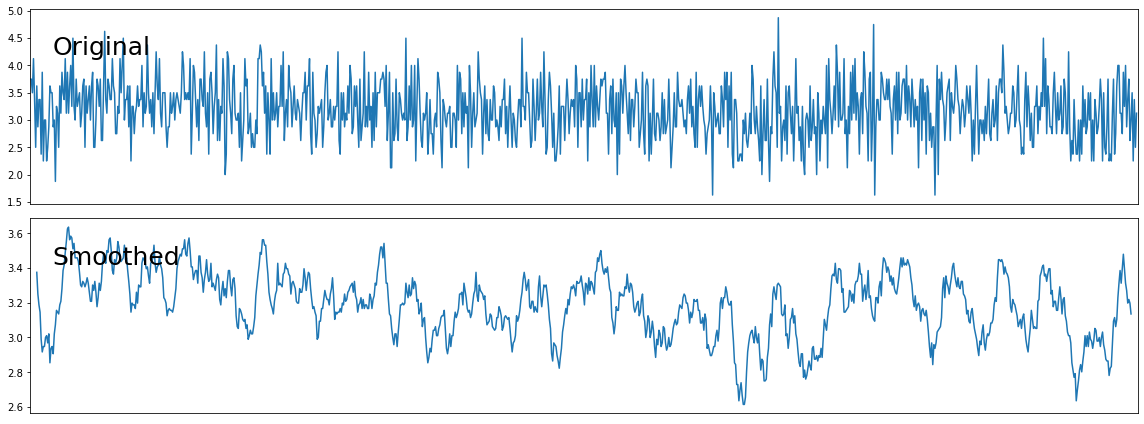

In [ ]:
# Sentiment
raw_data = load_csv('pure_sentiment.csv')
raw_data_int = [int(a) for a in raw_data]

raw_data_int

window_size, slide_size = smooth_ASAP(raw_data_int, resolution=1000)
#window_size, slide_size = smooth_simple(raw_data, resolution=1000)
print("Window Size: ", window_size)
plot(raw_data, window_size, slide_size)